# Setup

In [215]:
!pip install fastai > /dev/null

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [216]:
import pandas as pd
import seaborn as sns

from fastai import callback
from fastai.tabular.all import *

In [228]:
pd_clean_train = pd.read_csv("./data/clean/train.csv", index_col='PassengerId')
pd_clean_test = pd.read_csv("./data/clean/test.csv", index_col='PassengerId')
pd_sample_submission = pd.read_csv("../input/sample_submission.csv")

In [229]:
pd_clean_train.info()
pd_clean_train.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Survived     100000 non-null  int64  
 1   Pclass       100000 non-null  int64  
 2   Name         100000 non-null  object 
 3   Sex          100000 non-null  object 
 4   Age          96708 non-null   float64
 5   SibSp        100000 non-null  int64  
 6   Parch        100000 non-null  int64  
 7   Ticket       95377 non-null   object 
 8   Fare         99866 non-null   float64
 9   Cabin        32134 non-null   object 
 10  Embarked     99750 non-null   object 
 11  family       100000 non-null  int64  
 12  ticket_type  24655 non-null   object 
 13  ticket_num   94704 non-null   float64
dtypes: float64(3), int64(5), object(6)
memory usage: 11.4+ MB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family,ticket_type,ticket_num
PassengerId,,,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S,2,NaN,209245.0


# Create Modeling Datasets

In [232]:
CONT_FEATS = ['Age', 'Fare']
CAT_FEATS = ['Sex', 'Embarked', 'Parch', 'Pclass', 'family', 'SibSp', 'ticket_type']


def format_dataset(pd_df):
    dataset_cols = CONT_FEATS + CAT_FEATS + ['Survived']
    
    return pd_df.loc[:, [col for col in dataset_cols if col in pd_df.columns]]


def transform_survived_col(pd_df):
    return pd_df.assign(Survived=pd_df.Survived.astype(np.float16))

In [233]:
pd_model_train = (pd_clean_train
    .pipe(transform_survived_col)
    .pipe(format_dataset))
pd_model_test = (pd_clean_test
    .pipe(format_dataset))

# Create Modeling Dataset

In [235]:
tp_train = TabularPandas(
    df=pd_model_train, 
    procs=[Categorify, FillMissing, Normalize], 
    cat_names=CAT_FEATS, 
    cont_names=CONT_FEATS, 
    y_names='Survived',
    y_block=CategoryBlock(),
    splits=RandomSplitter(valid_pct=0.2)(range_of(pd_model_train)))

In [236]:
# Save
save_pickle('./data/model/nn_tp_train.pkl', tp_train)

In [237]:
# Read
tp_train = pickle.load(open('./data/model/nn_tp_train.pkl', "rb"))

In [238]:
print("Raw Input:")
tp_train.show(3)
print("Preprocessed Input:")
tp_train.items.head(3)

Raw Input:


,Sex,Embarked,Parch,Pclass,family,SibSp,ticket_type,Age_na,Fare_na,Age,Fare,Survived
PassengerId,,,,,,,,,,,,
10183,male,S,0,3,0,0,#na#,False,False,49.0,11.32,0.0
87771,male,S,0,1,0,0,STONO,False,False,57.0,7.98,0.0
42906,male,S,0,1,0,0,#na#,False,False,32.0,28.17,0.0


Preprocessed Input:


,Age,Fare,Sex,Embarked,Parch,Pclass,family,SibSp,ticket_type,Survived,Age_na,Fare_na
PassengerId,,,,,,,,,,,,
10183,0.591076,-0.468493,2,3,1,3,1,1,0,0,1,1
87771,1.035221,-0.516568,2,3,1,1,1,1,26,0,1,1
42906,-0.352733,-0.225955,2,3,1,1,1,1,0,0,1,1


# Train Model

In [239]:
# Create dataloader object
dls = tp_train.dataloaders(bs=64)

In [240]:
# Create model
learner = tabular_learner(dls, metrics=accuracy)

In [241]:
%%time
# Fit model
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.496316,0.494243,0.767400,00:15
1,0.480881,0.494406,0.768000,00:15
2,0.489471,0.490166,0.769450,00:15
3,0.487839,0.487780,0.771050,00:15
4,0.478928,0.488183,0.770750,00:15


CPU times: user 3min 19s, sys: 1min 53s, total: 5min 12s
Wall time: 1min 18s


In [242]:
# Save model
!rm ./models/nn.pth  # remove previously saved model
learner.save('nn')  # automatically prefixes "./models/"

Path('models/nn.pth')

In [243]:
# Read model
learner.load('nn')  # automatically prefixes "./models/"

# Analyze Model

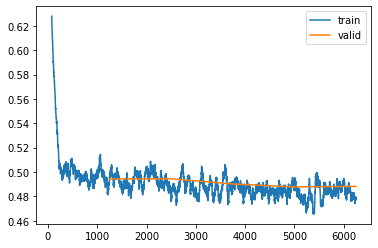

In [244]:
learner.recorder.plot_loss(skip_start=75)

In [245]:
learner.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(4, 3)
    (2): Embedding(9, 5)
    (3): Embedding(4, 3)
    (4): Embedding(17, 8)
    (5): Embedding(8, 5)
    (6): Embedding(31, 11)
    (7): Embedding(3, 3)
    (8): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=46, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

In [246]:
learner.summary()

TabularModel (Input shape: 64 x torch.Size([64, 2]))
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 3              
Embedding                                 9          True      
Embedding                                 12         True      
____________________________________________________________________________
                     64 x 5              
Embedding                                 45         True      
____________________________________________________________________________
                     64 x 3              
Embedding                                 12         True      
____________________________________________________________________________
                     64 x 8              
Embedding                                 136        True      
____________________________________________________________________________
                     64 x 5              
Embedding                                 40 

# Create Submission

In [247]:
# Create test dataloader
dl_test = learner.dls.test_dl(pd_model_test)

In [249]:
# Get predictions
probs, _ = learner.get_preds(dl=dl_test)
preds = torch.argmax(probs, dim=1)

In [250]:
# Create sumbission dataset
pd_submission = pd_sample_submission.assign(Survived=preds)
pd_submission.to_csv('./submissions/2.1-modelling-fastai.csv', index=False)